In [30]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, norm, expon
from statsmodels.distributions.empirical_distribution import ECDF
import random

In [91]:
def plot_algorithm_results(generated_numbers, algorithm_name, n_bins=100):
    plt.figure(figsize=(10, 6))
    plt.hist(generated_numbers,bins=n_bins,density=True,alpha=0.7)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Generated Numbers - {algorithm_name}")
    plt.show()

### Task A

Implement a linear congruential generator (LCG) with given parameters.

Linear formula:

$$
x_{n+1} = (a_1 x_n + a_0) \mod m
$$

To obtain numbers in the \([0,1]\) range, normalize:

$$
y_n = \frac{x_n}{m - 1}
$$


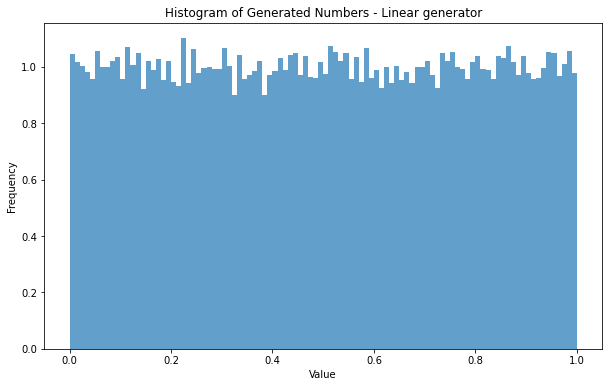

In [92]:
k=1
m=2**35
a1=math.floor(math.pi*10**9)
a0=math.floor(math.e*10**9)
n=50000 #number of generated numbers
seed=121 #initial seed value = x0

def linear_generator(seed, a1, a0, m, n):
    x = seed
    generated_numbers=[]
    for i in range(n):
        x = (a1 * x + a0) % m #linear formula
        normalized_x=x/(m-1) #normalize to [0,1]
        generated_numbers.append(normalized_x)
    return generated_numbers

generated_numbers=linear_generator(seed, a1, a0, m, n)
plot_algorithm_results(generated_numbers, "Linear generator")

### Task b

Using the elimination method (or its modification), generate random variables from a distribution with the following probability density function:

$$
f(x) = \frac{1 + \cos(2 \pi x)}{1 + e^{-2 \pi^2}} \cdot \frac{e^{-\frac{x^2}{2}}}{\sqrt{2 \pi}}
$$

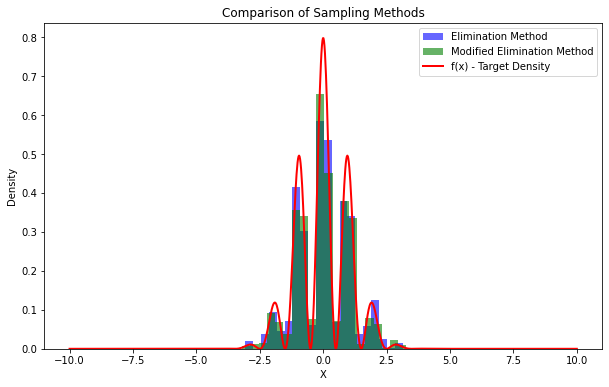

In [29]:
#density function f
def f(x):
    cos_part = 1 + math.cos(2 * math.pi * x)
    exp_part = math.exp(-x**2 / 2)
    denominator = (1 + math.exp(-2 * math.pi**2))
    
    return cos_part* exp_part / (denominator*math.sqrt(2 * math.pi))

#normal distribution function as g
def g(x, mu=0, sigma=1):
    return (1 / (math.sqrt(2 * math.pi * sigma**2))) * np.exp(- (x - mu)**2 / (2 * sigma**2))

def elimination_method(a, b, d):
    while True:
        X = np.random.uniform(a, b)
        Y = np.random.uniform(0, d)
        if Y <= f(X):
            return X

def modified_elimination_method(a, b, c):
    while True:
        X = np.random.normal(0, 1)
        Y = np.random.uniform(0, 1)
        
        if Y <= (f(X) / (c * g(X))):
            return X

c=10 #number greater than 1, f(x) <= c * g(x)
a, b = -10, 10
n=1000 #number of generated samples

X_elimination_method=[elimination_method(a,b,100) for _ in range(n)]
X_modified_elimination_method=[modified_elimination_method(a,b,c) for _ in range(n)]

#visualize the distribution of generated numbers
plt.figure(figsize=(10, 6))
plt.hist(X_elimination_method, bins=20, density=True, alpha=0.6, color='b', label="Elimination Method")
plt.hist(X_modified_elimination_method, bins=20, density=True, alpha=0.6, color='g', label="Modified Elimination Method")

#plot target density
x_vals = np.linspace(a, b, 1000)
y_vals = [f(x) for x in x_vals]
plt.plot(x_vals, y_vals, label="f(x) - Target Density", color='r', linewidth=2)

plt.xlabel('X')
plt.ylabel('Density')
plt.legend()
plt.title("Comparison of Sampling Methods")
plt.show()

### Task c

Generate a sequence of random variables from the Poisson distribution using two methods.

In [111]:
#poisson distribution probability mass function
def poisson_pmf(k, lam):
    if k < 0:
        return 0
    return (lam**k * np.exp(-lam)) / math.factorial(k)

In [112]:
def poisson_inversion(lam):
    u = np.random.uniform(0,1)
    sum_prob = math.exp(-lam) #P(X=0) <=> k=0
    k=0
    #until the sum of probabilities exceeds U, we generate values of k
    while u>sum_prob:
        k+=1 #this represents the next possible value for X
        sum_prob+=poisson_pmf(k,lam)
    return k

In [127]:
def poisson_discrete_sampling(lam, max_k=100):
    values = np.arange(0, max_k + 1)
    prob = np.array([poisson_pmf(k, lam) for k in values]) #p_i for each k
    cumulative_prob = np.cumsum(prob) #q
    cumulative_prob = np.insert(cumulative_prob, 0, 0)
    u = np.random.uniform(0, 1)
    
    #we look for k such that cumulative_prob[k-1]<u<=cumulative_prob[k]
    for i in range(len(cumulative_prob)):
        if cumulative_prob[i] >= u:
            return values[i]

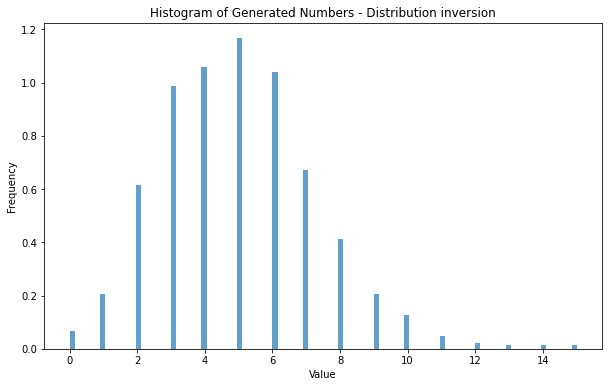

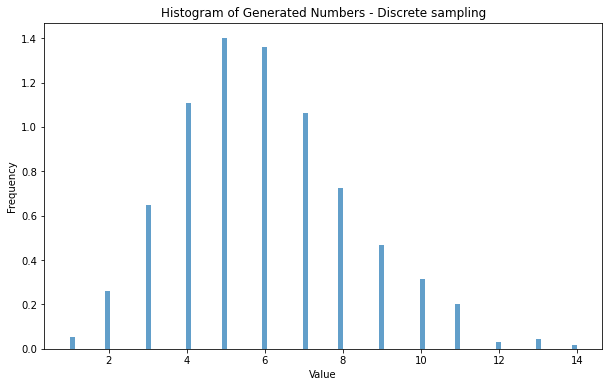

In [128]:
lam=5
n=1000
generated_numbers_inversion = [poisson_inversion(lam) for _ in range(n)]
generated_numbers_discrete_sampling = [poisson_discrete_sampling(lam, 100) for _ in range(n)]

plot_algorithm_results(generated_numbers_inversion, "Distribution inversion")
plot_algorithm_results(generated_numbers_discrete_sampling, "Discrete sampling")

### Task d

Generate a large number of random numbers from a distribution with the following cumulative distribution function (CDF):

$$
F(x) = \frac{1}{3} F_b(10, \frac{1}{3})(x) + \frac{1}{3} \Phi(x) + \frac{1}{3} F_{\text{EXP}}(1)(x)
$$

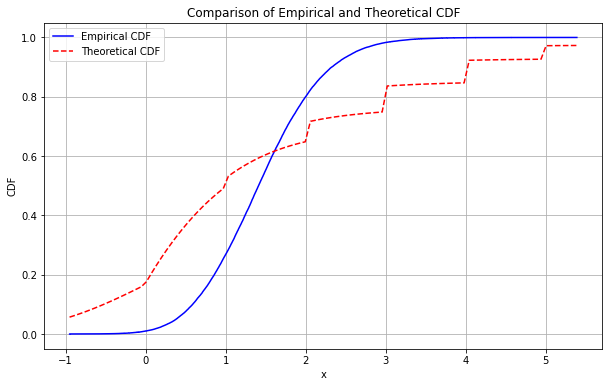

In [29]:
def generate_samples(n):
    #generating sample from each of the components in distribution function
    F_b_samples = binom.rvs(10, 1/3, size=n)
    F_norm_samples = norm.rvs(size=n)
    F_exp_samples = expon.rvs(scale=1, size=n)
    return (1/3) * F_b_samples + (1/3) * F_norm_samples + (1/3) * F_exp_samples

def theoretical_distribution(x):
    F_b = binom.cdf(x, 10,1/3)
    F_norm = norm.cdf(x)
    F_exp = expon.cdf(x, scale=1)
    return (1/3) * F_b + (1/3) * F_norm + (1/3) * F_exp

n=50000
samples=generate_samples(n)
#empirical distribution function from generated samples
ecdf = ECDF(samples)

x_values = np.linspace(min(samples), max(samples), 100)
theoretical_values = theoretical_distribution(x_values)

#comparing empirical and theoretical distribution
plt.figure(figsize=(10, 6))
plt.step(ecdf.x, ecdf.y, label='Empirical CDF', color='b')
plt.plot(x_values, theoretical_values, label='Theoretical CDF', color='r', linestyle='--')
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Comparison of Empirical and Theoretical CDF')
plt.legend()
plt.grid(True)
plt.show()

### Task e

KISS algorithm

This algorithm is described in detail in the paper by Marsaglia [link](https://eprint.iacr.org/2011/007.pdf). 


```c
#include <stdio.h>
#include <stdint.h>

uint32_t z = 0x12345678;     
uint32_t w = 0x23456789;     
uint32_t jsr = 0x34567890;   
uint32_t jcong = 0x45678901; 

#define znew (z = 36969 * (z & 65535) + (z >> 16))
#define wnew (w = 18000 * (w & 65535) + (w >> 16))
#define MWC ((znew << 16) + wnew)
#define SHR3 (jsr ^= (jsr << 17), jsr ^= (jsr >> 13), jsr ^= (jsr << 5))
#define CONG (jcong = 69069 * jcong + 1234567)
#define KISS ((MWC ^ CONG) + SHR3)

int main() {
    for (int i = 0; i < 1000; i++) {
        uint32_t generated_number = KISS;
        printf("%u\n", generated_number); 
    }
    return 0;
}

In [63]:
random_state_shr3=random.getrandbits(32)
random_state_mwc_x=random.getrandbits(16)
random_state_mwc_y=random.getrandbits(16)
carry=0
random_state_cong=random.getrandbits(32)

In [65]:
def shr3_generator(): #3-shift register generator
    global random_state_shr3
    random_state_shr3 ^= (random_state_shr3 << 13) & 0xFFFFFFFF #left shift by 13 positions and apply 0xFFFFFFFF to limit to 32 bits to prevent overflow
    random_state_shr3 ^= (random_state_shr3 >> 17) #right shift by 17 positions, no masking needed as Python handles positive integers correctly
    random_state_shr3 ^= (random_state_shr3 << 5) & 0xFFFFFFFF 
    return random_state_shr3 & 0xFFFFFFFF

In [66]:
def mwc_generator():
    global random_state_mwc_x, random_state_mwc_y, carry
    x_new=(36969*random_state_mwc_x+carry)%(2**16)
    y_new=(18000*random_state_mwc_y+carry)%(2**16)
    carry = (x_new >> 16) + (y_new >> 16)

    result=(x_new & 0xFFFF) ^ (y_new & 0xFFFF)  # XOR the lower 16 bits of x_new and y_new
    random_state_mwc_x, random_state_mwc_y=x_new,y_new
    return result

In [67]:
def cong_generator():
    global random_state_cong
    random_state_cong=(69069*random_state_cong+1234567)%(2**32)
    return random_state_cong

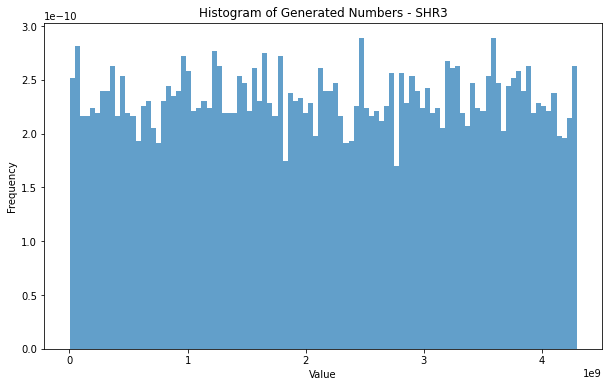

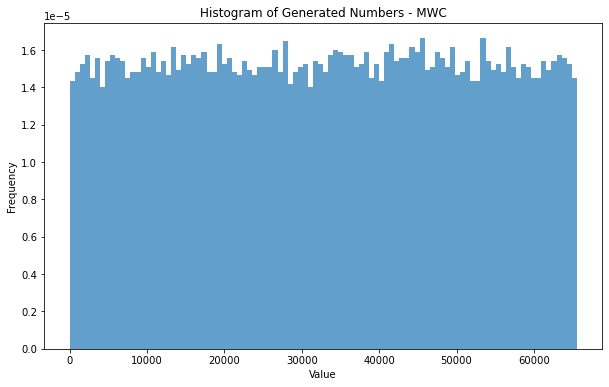

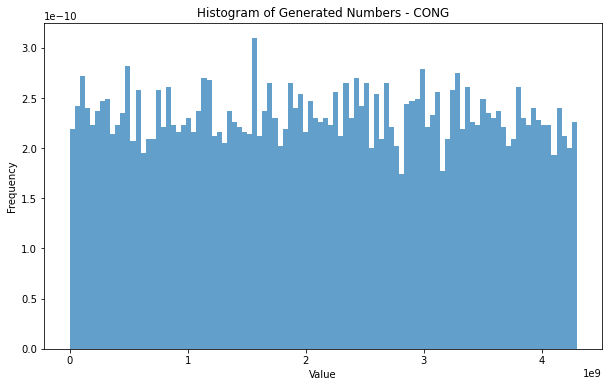

In [81]:
shr3_values = [shr3_generator() for _ in range(10000)]
mwc_values = [mwc_generator() for _ in range(10000)]
cong_values = [cong_generator() for _ in range(10000)]

plot_algorithm_results(shr3_values, 'SHR3')
plot_algorithm_results(mwc_values, 'MWC')
plot_algorithm_results(cong_values, 'CONG')

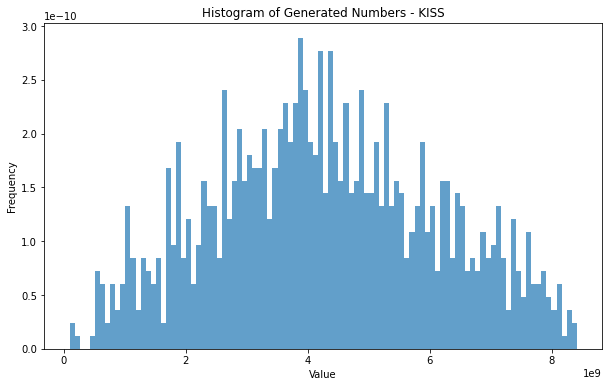

In [84]:
# KISS generator that combines SHR3, MWC, and CONG
def kiss_generator():
    mwc_value = mwc_generator()
    shr3_value = shr3_generator()
    cong_value = cong_generator()
    return (mwc_value ^ cong_value) + shr3_value  # XOR MWC and CONG, then add SHR3 result

kiss_generated_numbers=[]
for i in range(1000):
    kiss_generated_numbers.append(kiss_generator())

plot_algorithm_results(kiss_generated_numbers, "KISS")